## 1. Data preparation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import statsmodels.api as sm

In [3]:
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = [14.0, 10.0]

In [4]:
sns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [5]:
# month = df.drop(columns = ['Total'])

df = pd.read_csv('HKAirPassengers.csv', parse_dates = ['Month'], index_col = ['Month'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 1998-01-01 to 2020-06-01
Data columns (total 1 columns):
Total    270 non-null int64
dtypes: int64(1)
memory usage: 4.2 KB


In [7]:
df.dtypes

Total    int64
dtype: object

In [8]:
df

,Total
Month,
1998-01-01,2230452
1998-02-01,2005008
1998-03-01,2169781
1998-04-01,2336505
1998-05-01,2129127
...,...
2020-02-01,1877718
2020-03-01,575825
2020-04-01,31739


In [9]:
df.astype(str).astype('int64')

,Total
Month,
1998-01-01,2230452
1998-02-01,2005008
1998-03-01,2169781
1998-04-01,2336505
1998-05-01,2129127
...,...
2020-02-01,1877718
2020-03-01,575825
2020-04-01,31739


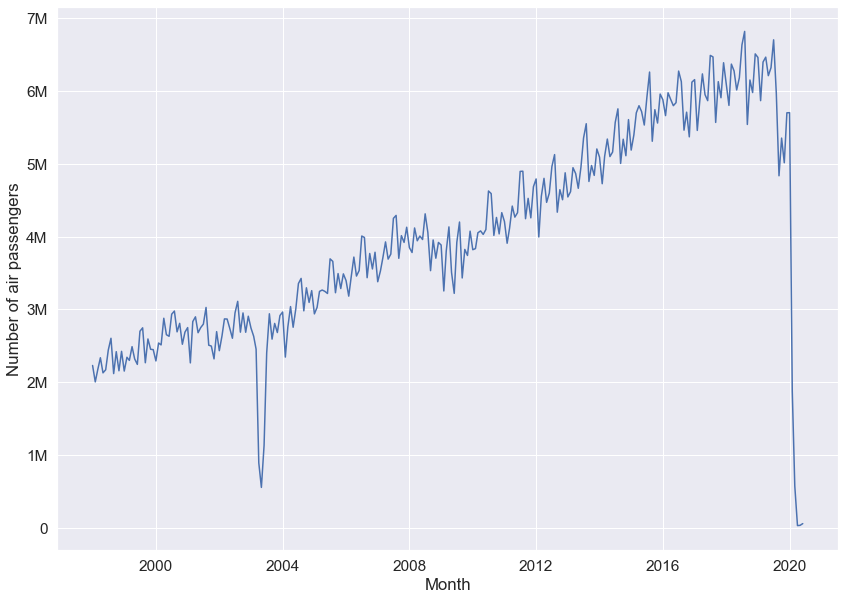

In [10]:
# Plot time series graph
plt.xlabel('Month')
plt.ylabel('Number of air passengers')
plt.plot(df)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

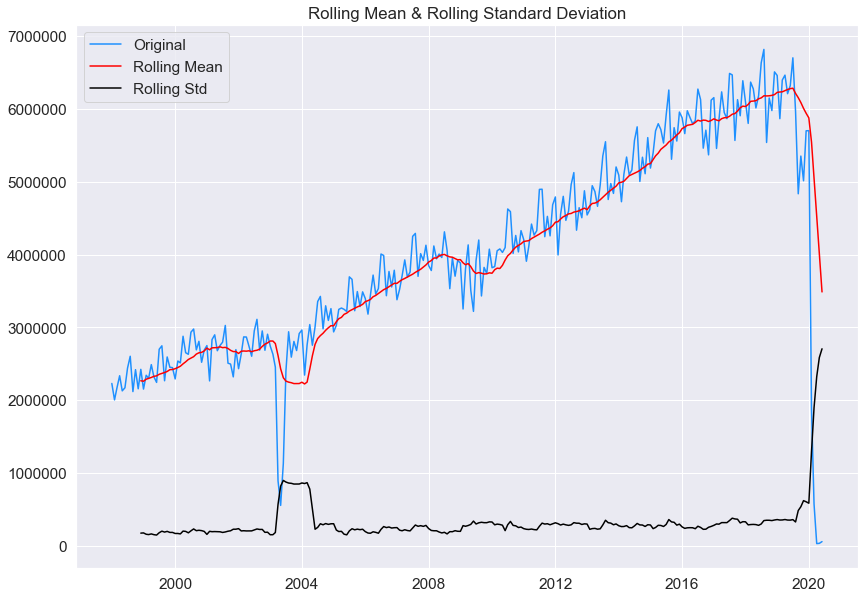

In [11]:
#Plot MA graph
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'dodgerblue', label = 'Original', linewidth = 1.5)
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean', linewidth = 1.5)
plt.plot(rolling_std, color = 'black', label = 'Rolling Std', linewidth = 1.5)
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')

plt.show()

In [12]:
result = adfuller(df['Total'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.6896512329392384
p-value: 0.43645220583921285
Critical Values:
	1%: -3.4561550092339512
	5%: -2.8728972266578676
	10%: -2.5728222369384763


## 2. Auto ARIMA

In [13]:
#divide into train and validation set
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]

In [14]:
# Drop 2020 data
# test = test[:-6]
# test

In [15]:
#preprocessing (since arima takes univariate series as input)
#train.drop('Month',axis=1,inplace=True)
#valid.drop('Month',axis=1,inplace=True)

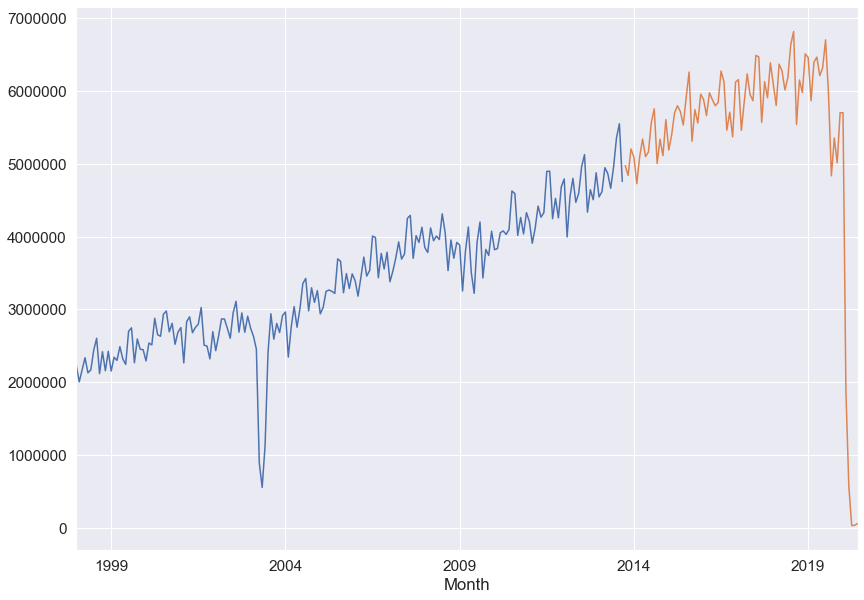

In [16]:
#plotting the data
train['Total'].plot()
test['Total'].plot()

In [17]:
# test the model is stationary or not
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train)

#(0.01,False) means non-stationary

C:\Users\nata\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\nata\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


(0.01, False)

In [18]:
# Build Auto arima model
arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, 
                         max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5,
                         max_Q=5, m=12, seasonal=True, error_action='warn', 
                         trace=True, supress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4977.829, BIC=4984.170, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4943.117, BIC=4955.799, Fit time=0.215 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4917.443, BIC=4930.125, Fit time=0.245 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4919.425, BIC=4935.278, Fit time=0.306 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4978.130, BIC=4987.642, Fit time=0.071 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=4919.413, BIC=4935.265, Fit time=0.460 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4919.904, BIC=4938.927, Fit time=0.751 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4916.718, BIC=4932.570, Fit time=0.270 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4916.442, BIC=4929.124, Fit time=0.195 seconds
Fit ARIMA: order=(2, 1, 1) s

In [19]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  189
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2452.451
Date:                            Sun, 26 Jul 2020   AIC                           4914.902
Time:                                    05:53:53   BIC                           4930.755
Sample:                                         0   HQIC                          4921.332
                                            - 189                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2172.0870   1.12e+04      0.194      0.847   -1.98e+04    2.42e+04
ar.L1         -0.0349      0.080     -0.438      0.661      -0.191       0.121
ar.L2         -0.1181      0.106     -1.113      0.266      -0.326       0.090
ma.S.L12      -0.7378      0.093     -7.905      0.000      -0.921      -0.555
sigma2      1.063e+11      0.006   1.64e+13      0.000    1.06e+11    1.06e+11
===================================================================================
Ljung-Box (Q):                       32.98   Jarque-Bera (JB):               933.67
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.17e+28. Standard errors may be unstable.
"""

In [20]:
test

,Total
Month,
2013-10-01,4976160
2013-11-01,4840428
2013-12-01,5203479
2014-01-01,5091264
2014-02-01,4726156
...,...
2020-02-01,1877718
2020-03-01,575825
2020-04-01,31739


In [21]:
# Forecast testing set values
prediction = pd.DataFrame(arima_model.predict(n_periods = 81), index=test.index)
prediction.columns = ['predicted_passengers']
prediction

,predicted_passengers
Month,
2013-10-01,5.058386e+06
2013-11-01,4.898861e+06
2013-12-01,5.224749e+06
2014-01-01,5.076149e+06
2014-02-01,4.843527e+06
...,...
2020-02-01,7.239911e+06
2020-03-01,7.599312e+06
2020-04-01,7.713466e+06


C:\Users\nata\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'left conrner'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


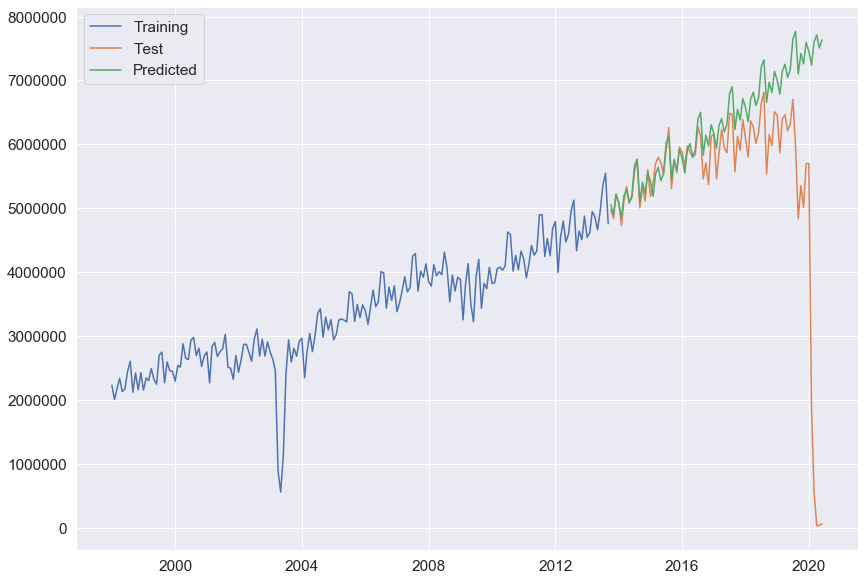

In [22]:
# plot testing set value and its forecast
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(prediction, label = 'Predicted')
plt.legend(loc = 'left conrner')
plt.show()

In [23]:
# check r2 score
from sklearn.metrics import r2_score
test['predicted_passengers'] = prediction
r2_score(test['Total'], prediction['predicted_passengers'])

C:\Users\nata\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


-0.9065107241892811

### Appendix 1.1 ACF

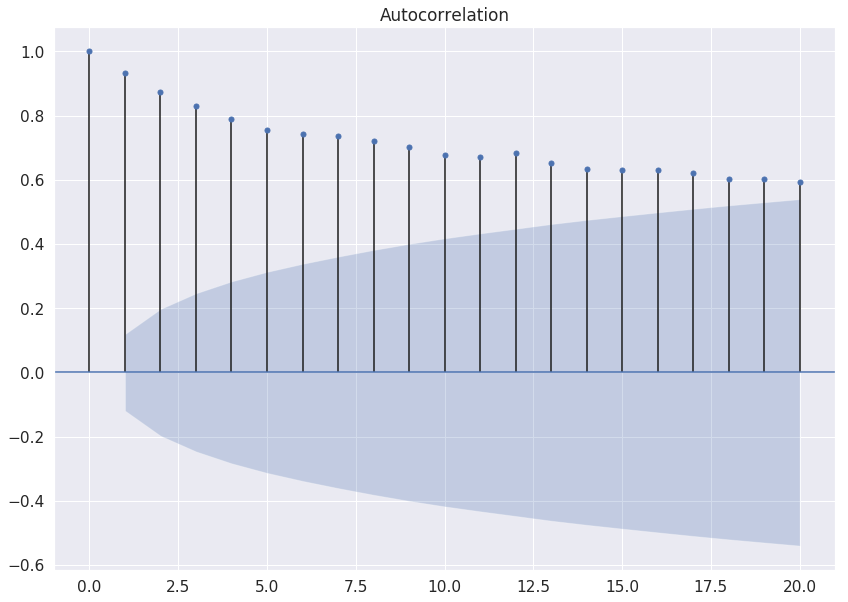

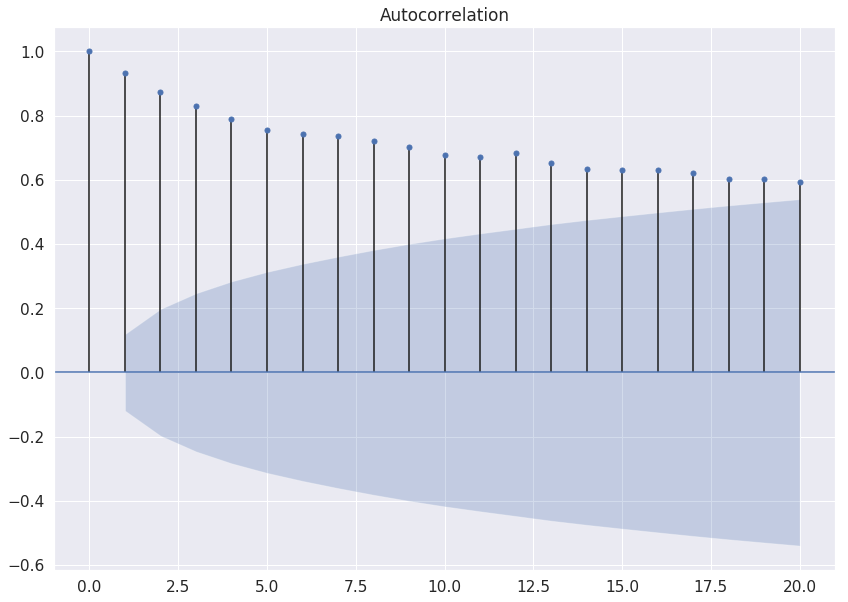

In [46]:
# ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Total'], lags = 20, alpha = 0.05)

In [47]:
from statsmodels.tsa.stattools import acf
print(acf(df['Total']))

[1.         0.93307419 0.87325704 0.82966252 0.79025023 0.75665234
 0.74145754 0.7364233  0.72234758 0.702244   0.67773484 0.66987288
 0.68479765 0.65106853 0.63345474 0.63200011 0.6306913  0.62089285
 0.60306632 0.60188267 0.5945804  0.57976431 0.55917417 0.55736727
 0.57194235 0.54125215 0.52447008 0.52264087 0.52078487 0.51035338
 0.49199371 0.4891591  0.48419924 0.47214178 0.45371957 0.45189741
 0.46920787 0.43830561 0.42089058 0.42440105 0.42325963]


### Appendix 1.2 PACF

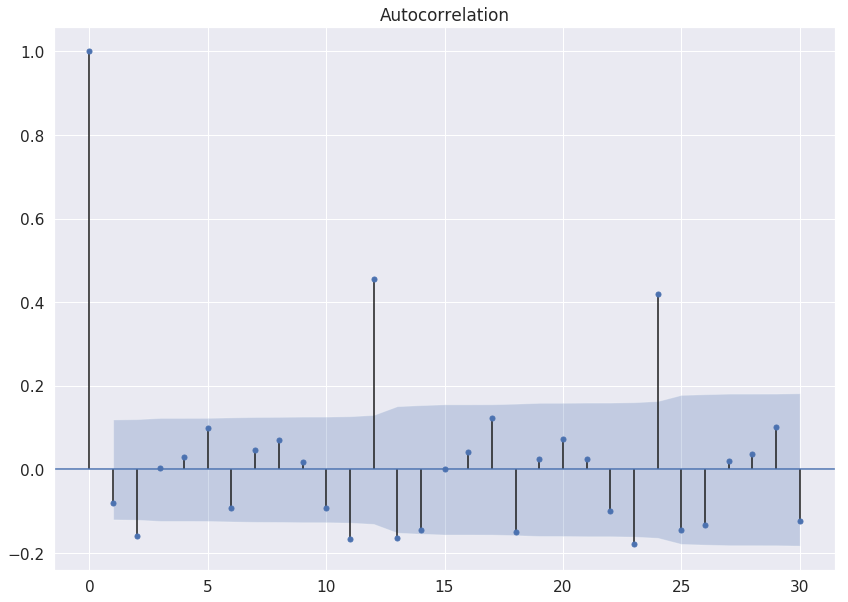

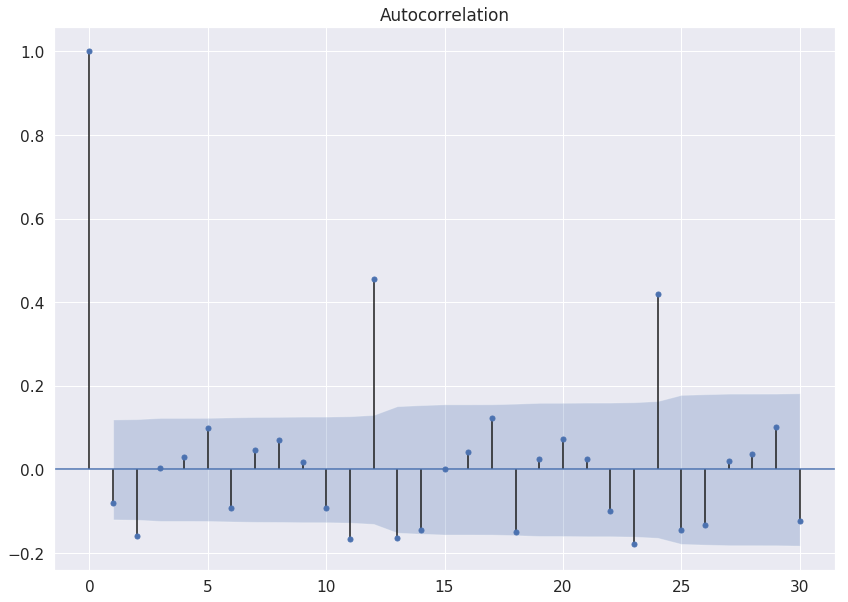

In [48]:
# Differencing
df_diff = df.diff()
df_diff = df_diff.dropna()

# Plot ACF
plot_acf(df_diff, lags = 30)

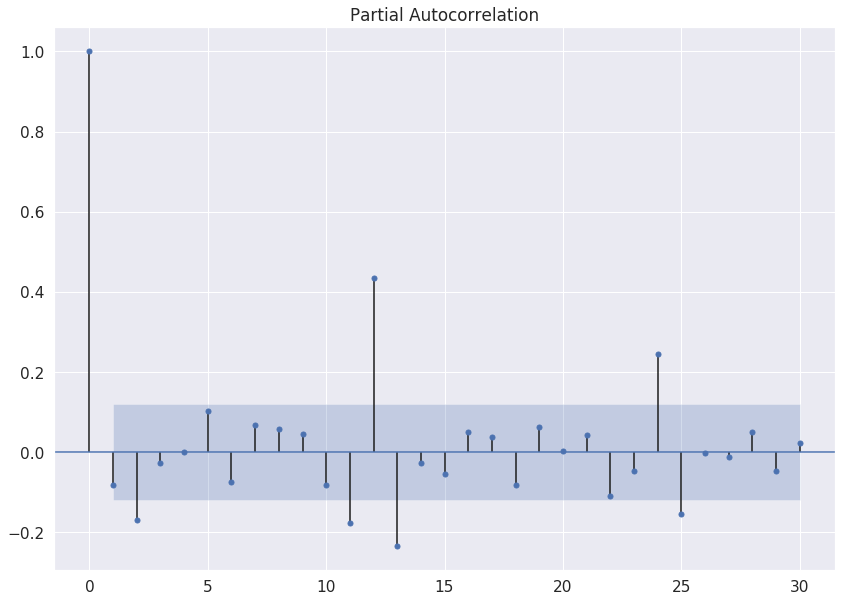

In [49]:
# Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_diff, lags = 30)
plt.show()

### Appendix 1.3 Seasonal differencing

In [50]:
# Seasonal Differencing
df_sdiff = df.diff(12)
df_sdiff = df_sdiff.dropna()

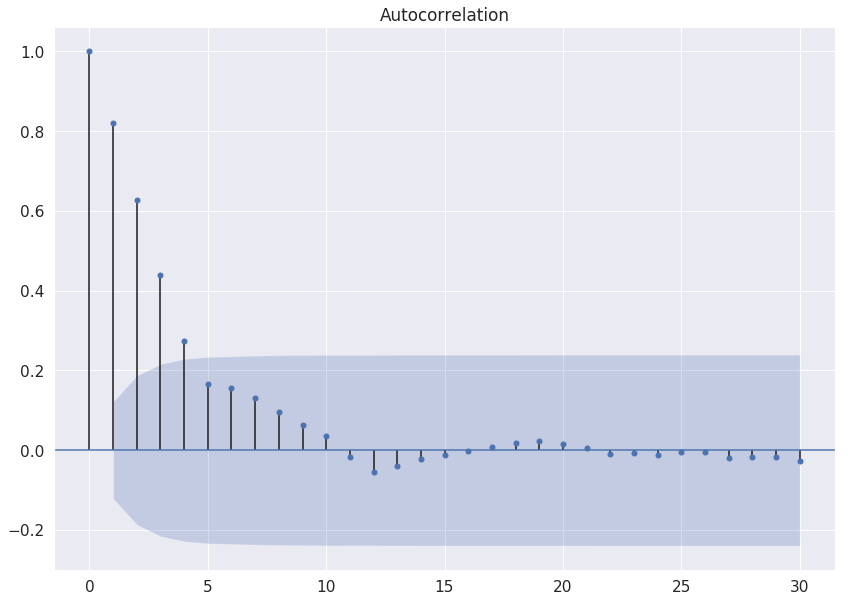

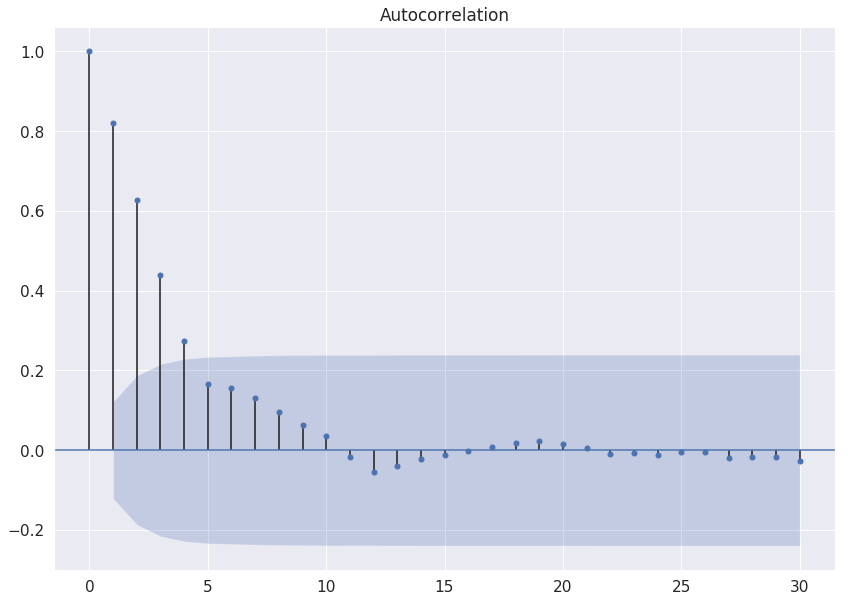

In [51]:
# Plot ACF
plot_acf(df_sdiff, lags=30)

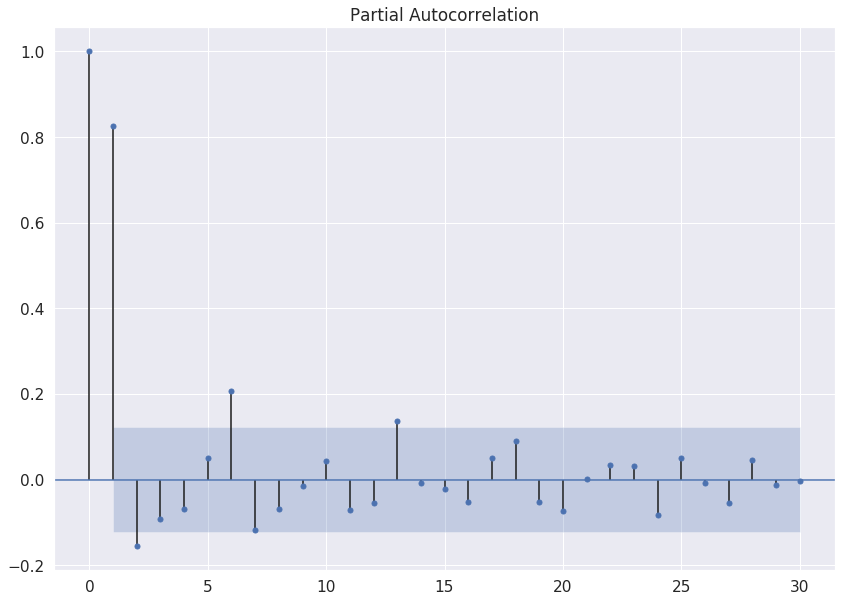

In [52]:
# Plot PACF
plot_pacf(df_sdiff, lags=30)
plt.show()